In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_letters

from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR

import xgboost as xgb
import lightgbm as lgb

from tqdm import tqdm

agg_data = pd.read_csv("agg_data5.csv")
agg_data.head()

,pdf,project_name,country,multiple_phases,number_countries,eval_year,number_sectors,number_subsectors,mean_investment,number_funding_source,...,count_dominieren_die,count_unzureichend,count_geringen,count_maengel,count_nicht_erfolgreich,count_nicht_erfolgreiche,count_ueberwiegend_nicht,count_auch_nicht,count_ueberwiegend_nicht_erfolgreich,count_vorhaben_ist_nutzlos
0,%C3%84gypten_Qena_2022_D.pdf,Kommunale Wasserver- und Abwasserentsorgung Qena,Egypt,0,1,2022,1,1,12670000.0,1,...,2,4,7,3,9,4,2,1,2,1
1,%C3%84gypten_Umwelt_2022_D.pdf,Förderung von Umweltschutzmaßnahmen der privat...,Egypt,0,1,2022,1,1,25780000.0,1,...,2,6,5,1,6,3,2,1,2,1
2,%C3%84thiopien_Gavi_2022_D.pdf,Impfprogrammförderung in Äthiopien in Zusammen...,Ethiopia,0,1,2022,1,1,10000000.0,1,...,0,1,0,1,3,1,0,2,0,0
3,Afrika_TCX_2012_D.pdf,Lokalwährungsfonds TCX,Afrika (regional),0,1,2012,1,1,90000000.0,1,...,2,1,0,1,2,2,0,1,0,1
4,Albanien_Elbasan_2011.pdf,Wirtschaftsförderung durch Ausbau kommunaler I...,Albania,0,1,2011,1,1,10600000.0,1,...,2,3,0,1,2,2,0,2,0,1


We again sepatate the agg_data in train (and test) and validation sets.

In [2]:
validation_data = agg_data.sample(frac=0.1, random_state = 123)
train_test_data = agg_data.drop(validation_data.index)
train_test_data.shape, validation_data.shape

((665, 73), (74, 73))

First, we check for missing values in the data:

In [3]:
print(train_test_data.isnull().sum()[train_test_data.isnull().sum() != 0])

country                   17
mean_investment            1
relevance                  1
coherence                576
effectivity                1
efficiency                 1
sustainability             5
invest_plan_vs_actual    207
dtype: int64


For the country analysis, we have our "secondary data" variables. The evaluation scores are not considered when predicting the overall score. The mean_investment column is also excluded due to the general unreliability of this specific variable. We will impute missing values in the investment_plan_vs_actual column using a KNN imputer for visaulization purposes. Later we implement the knn imputer in our modeling pipeline.

In [4]:
GENERAL_FEATURES = [
    'multiple_phases', 'number_countries', 'number_sectors', 
    'number_subsectors', 'number_funding_source', 'number_carrier_type'
]

OUTCOME_FEATURES = [
    'outcome_fully', 'outcome_partially', 'outcome_not'
]

CLUSTER_AND_INVESTMENT_FEATURES = [
    'cluster', 'invest_plan_vs_actual'
]

MANAGEMENT_AND_GOVERNANCE_FEATURES = [
    'adaptive_management', 'wbgi_gee', 'wdi_expedus', 'wdi_gdpind',
    'gpi_ss', 'bci_bcistd'
]

TEXTUAL_ANALYSIS_FEATURES = [
    'word_count', 'character_count', 'word_density', 'sentence_count',
    'avg_sentence_length', 'unique_word_count', 'digit_count',
    'punctuation_count'
]

SPECIFIC_TERM_COUNTS = [
    'count_deutlich', 'count_gut', 'count_erreicht', 'count_erfolgreich',
    'count_verbesserungen', 'count_erfuellt', 'count_umsetzung', 
    'count_zutreffend', 'count_verbesserung_der', 'count_beitrag_zur',
    'count_mit_hoher_wahrscheinlichkeit', 'count_deutlich_ueber_den',
    'count_gute', 'count_teilweise', 'count_allerdings', 'count_positiv',
    'count_positive', 'count_positiver', 'count_wirksamkeit_des_vorhabens',
    'count_bisher_positive', 'count_positive_entwicklungspolitische_wirksamkeit',
    'count_unter_den_erwartungen', 'count_die_negativen_ergebnisse',
    'count_dominieren_die', 'count_unzureichend', 'count_geringen',
    'count_maengel', 'count_nicht_erfolgreich', 'count_nicht_erfolgreiche',
    'count_ueberwiegend_nicht', 'count_auch_nicht',
    'count_ueberwiegend_nicht_erfolgreich', 'count_vorhaben_ist_nutzlos'
]

FEATURES = (
    GENERAL_FEATURES + OUTCOME_FEATURES + CLUSTER_AND_INVESTMENT_FEATURES +
    MANAGEMENT_AND_GOVERNANCE_FEATURES + TEXTUAL_ANALYSIS_FEATURES +
    SPECIFIC_TERM_COUNTS
)

TARGET = 'overall_rating'

FEATURES_AND_TARGET = FEATURES + [TARGET]

train_test_data = train_test_data[FEATURES_AND_TARGET]

Here we are searching for the best k parameter for the knn imputation. This is done by randomly imputing missing values to our dataframe and calculating the mse for each selected k. The higher k means that more observation are selected to determining the missing value, and vice-versa.

**This takes a while and can create slightly different results due to the randomness.**

In [5]:
train_test_data_k = train_test_data.drop(columns=["invest_plan_vs_actual"], axis=1)

# Testing several values for k
epochs = 10
folds = 20
missing_values_proportion = 0.3
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 18, 20, 22, 25, 30, 40, 50, 60]
mse_values = {k: [] for k in k_values}
best_k = []
best_mse = []

for e in tqdm(range(epochs)):

    for i in range(folds):
        # Generate a mask for missing values
        missing_mask = np.random.rand(*train_test_data_k.shape) < missing_values_proportion
        df_with_nan = train_test_data_k.copy()
        df_with_nan[missing_mask] = np.nan  # Apply the mask

        features = train_test_data_k.drop(columns=[TARGET])
        target = train_test_data_k[TARGET]
        features_with_nan = df_with_nan.drop(columns=[TARGET])
        
        for k in k_values:
            imputer = KNNImputer(n_neighbors=k)
            imputed_features = imputer.fit_transform(features_with_nan)
            
            imputed_data = np.hstack([imputed_features, target.values.reshape(-1, 1)])
            
            if not np.isnan(imputed_data).any():
                mse = mean_squared_error(train_test_data_k, imputed_data)
                mse_values[k].append(mse)
            else:
                mse_values[k].append(np.nan)

    avg_mse_values = {k: np.nanmean(mse_values[k]) for k in k_values}

    min_k = min(k_values, key=lambda k: avg_mse_values[k])
    min_mse = avg_mse_values[min_k]

    best_k.append(min_k)
    best_mse.append(min_mse)

# Print results
print("Average of best k:", np.mean(best_k), "(±", round(np.std(best_k), 2), ")" )
print("Average of MSE:", round(np.mean(best_mse), 2))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [10:49<00:00, 64.93s/it]

Average of best k: 22.0 (± 0.0 )
Average of MSE: 1097308.61


Now we impute the missing values in invest_plan_vs_actual in the train_test_dataframe with k=22. The relatively high value indicates that the variance in the dataset is a sligtly higher problem than the bias.

In [6]:
imputation_knn = KNNImputer(n_neighbors=22)
train_test_data_clean = imputation_knn.fit_transform(train_test_data)
train_test_data_clean = pd.DataFrame(train_test_data_clean, columns=train_test_data.columns)
train_test_data_clean.head()

,multiple_phases,number_countries,number_sectors,number_subsectors,number_funding_source,number_carrier_type,outcome_fully,outcome_partially,outcome_not,cluster,...,count_unzureichend,count_geringen,count_maengel,count_nicht_erfolgreich,count_nicht_erfolgreiche,count_ueberwiegend_nicht,count_auch_nicht,count_ueberwiegend_nicht_erfolgreich,count_vorhaben_ist_nutzlos,overall_rating
0,0.0,1.0,1.0,1.0,1.0,1.0,66.666667,33.333333,0.000000,3.0,...,4.0,7.0,3.0,9.0,4.0,2.0,1.0,2.0,1.0,3.0
1,0.0,1.0,1.0,1.0,1.0,1.0,100.000000,0.000000,0.000000,3.0,...,6.0,5.0,1.0,6.0,3.0,2.0,1.0,2.0,1.0,3.0
2,0.0,1.0,1.0,1.0,1.0,1.0,66.666667,0.000000,33.333333,3.0,...,1.0,0.0,1.0,3.0,1.0,0.0,2.0,0.0,0.0,3.0
3,0.0,1.0,1.0,1.0,1.0,1.0,100.000000,0.000000,0.000000,4.0,...,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,1.0,2.0
4,0.0,1.0,1.0,1.0,1.0,1.0,33.333333,16.666667,33.333333,2.0,...,3.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0,1.0,4.0


We now use the train_test_data_clean for visualization. The train_test_data still has missing values in investment_plan_vs_actual. We later impute nan in our modeling pipeline.

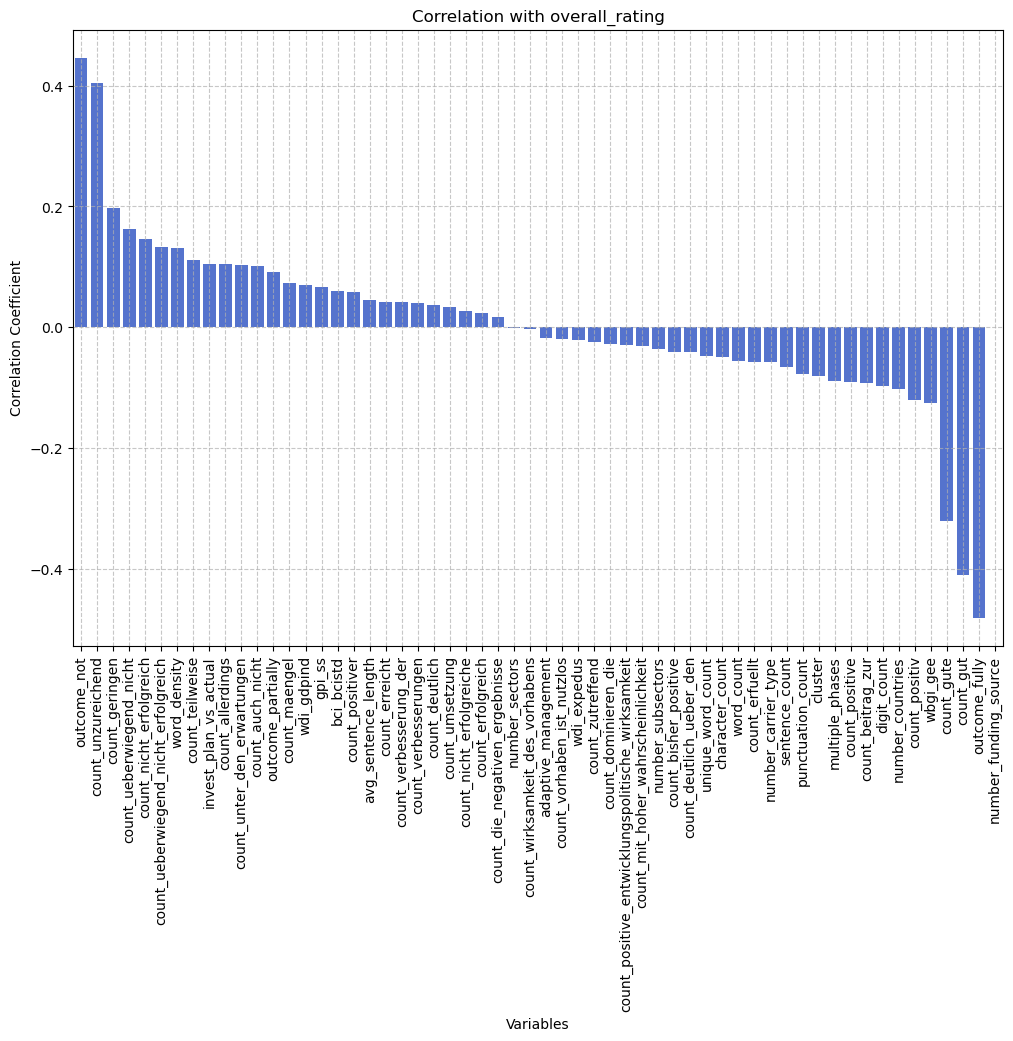

In [7]:
# Compute the correlation matrix and the target correlations
corr_matrix = train_test_data_clean[FEATURES + [TARGET]].corr()
target_corr = corr_matrix[TARGET].drop(TARGET)

# Sort the correlations from high to low
sorted_target_corr = target_corr.sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_target_corr.index, y=sorted_target_corr.values, color='royalblue')
plt.title(f'Correlation with {TARGET}')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

The correlation analysis reveals that `overall_rating` is notably influenced by certain factors. Strong negative correlations are found with `outcome_fully` and `count_gut`, indicating that higher ratings are associated with lower occurrences in these areas. Conversely, `outcome_not` shows a moderate positive correlation, suggesting that higher ratings align with more frequent instances of this outcome. Other variables, including `invest_plan_vs_actual` and several term counts, display weak or negligible correlations with `overall_rating`, emphasizing that only a few key factors significantly impact the rating.

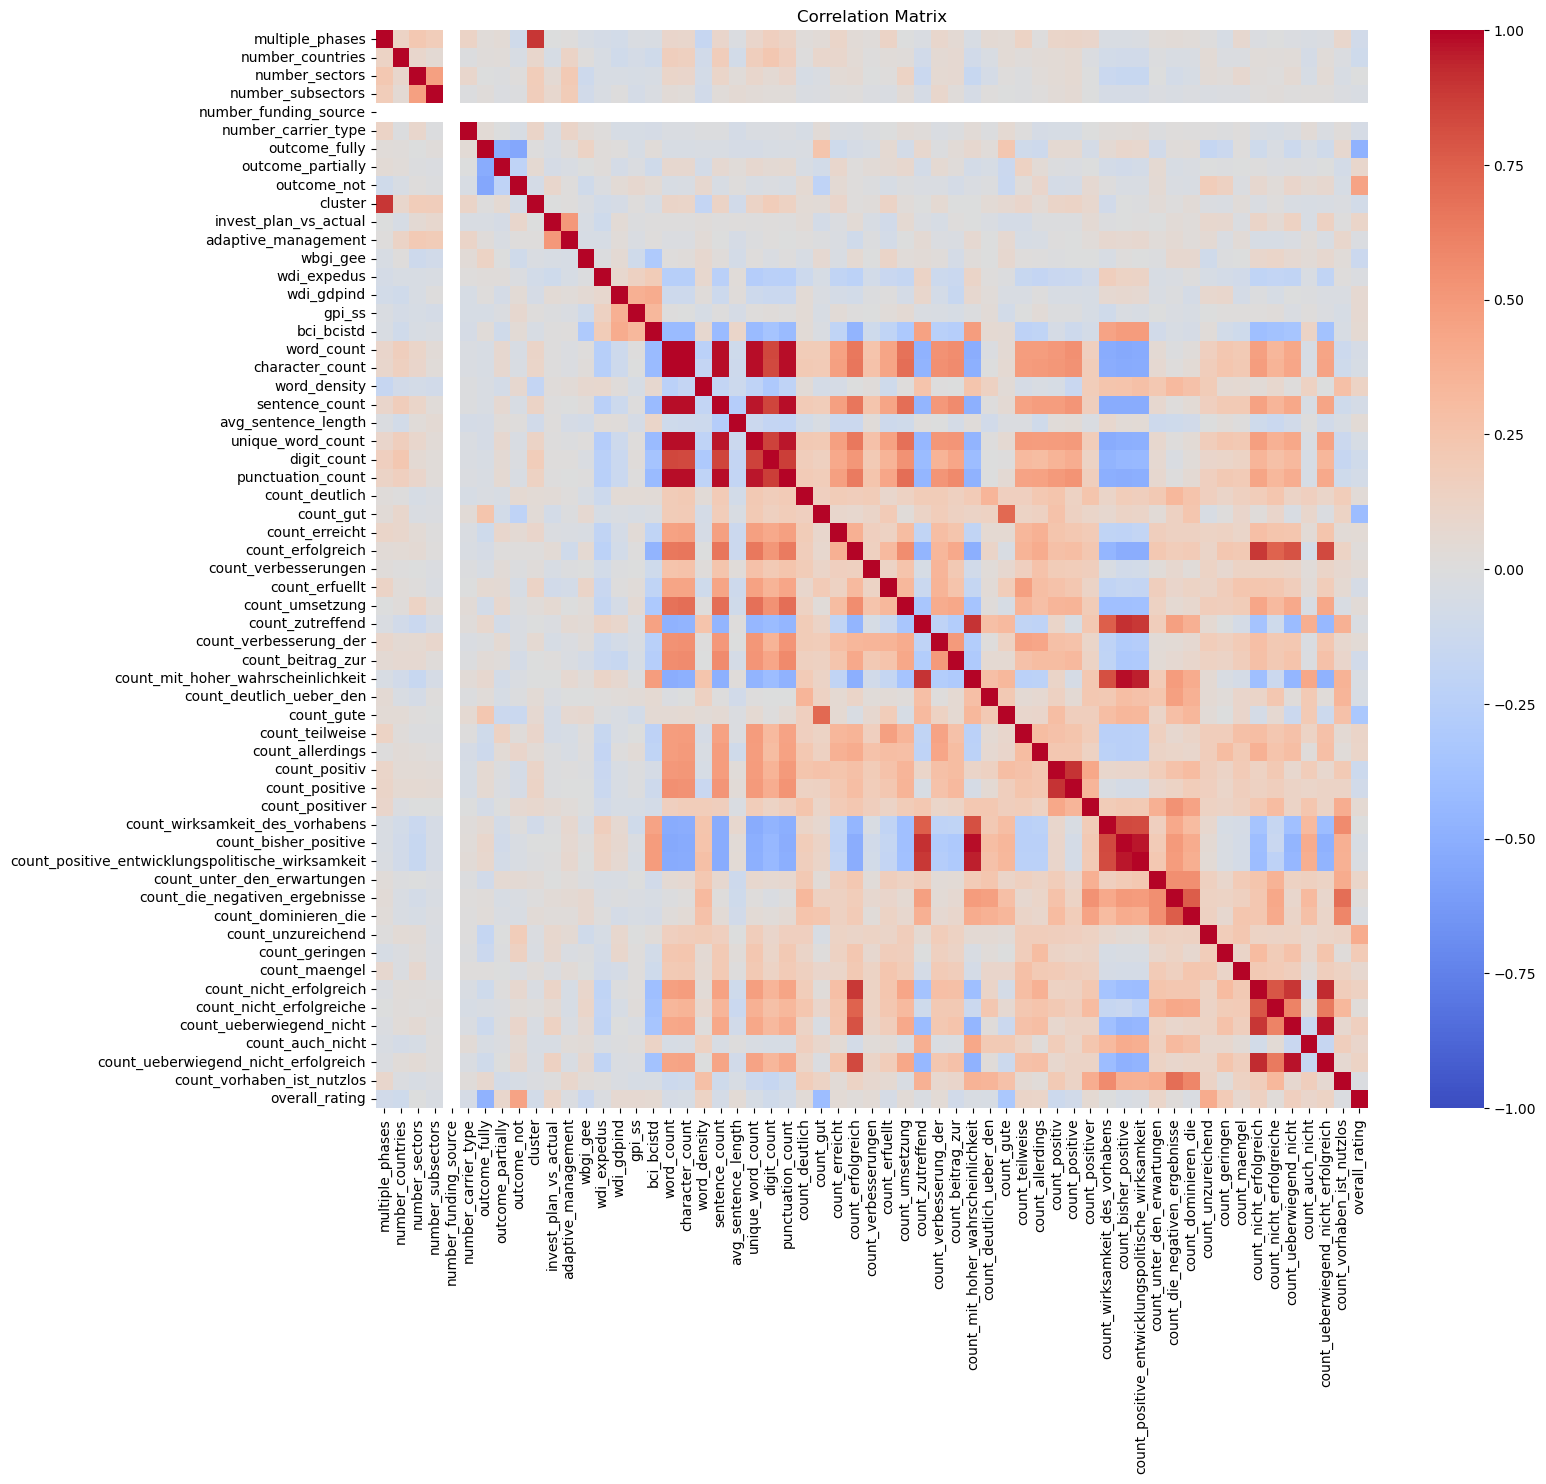

In [8]:
selected_columns = FEATURES + [TARGET]
corr_matrix = train_test_data_clean[selected_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

As shown in the correlation matrix, some variables exhibit high correlation which can lead to colinearity problems in regression. Therefore we exclude the respective variables from our feature list:

- count_ueberwiegend_nicht_erfolgreich
- cluster
- character_count
- word_count
- sentence_count
- punctuation_count
- unique_word_count
- count_zutreffend
- count_nicht_erfolgreich
- count_die_negativen_ergebnisse
- count_mit_hoher_wahrscheinlichkeit
- count_positive
- count_gute
- number_funding_source
- count_wirksamkeit_des_vorhabens
- count_positive_entwicklungspolitische_wirksamkeit
- count_erfolgreich
- count_nicht_erfolgreiche

In [9]:
train_test_data_clean = train_test_data_clean.drop(
    columns=["count_ueberwiegend_nicht_erfolgreich", "cluster", "character_count", "word_count", 
             "sentence_count", "punctuation_count", "count_zutreffend", "unique_word_count", 
             "count_nicht_erfolgreich", "count_die_negativen_ergebnisse", "count_mit_hoher_wahrscheinlichkeit",
             "count_positive", "count_gute", "number_funding_source", "count_wirksamkeit_des_vorhabens",
             "count_positive_entwicklungspolitische_wirksamkeit", "count_erfolgreich", "count_nicht_erfolgreiche"], 
    axis=1, 
    errors='ignore'
)

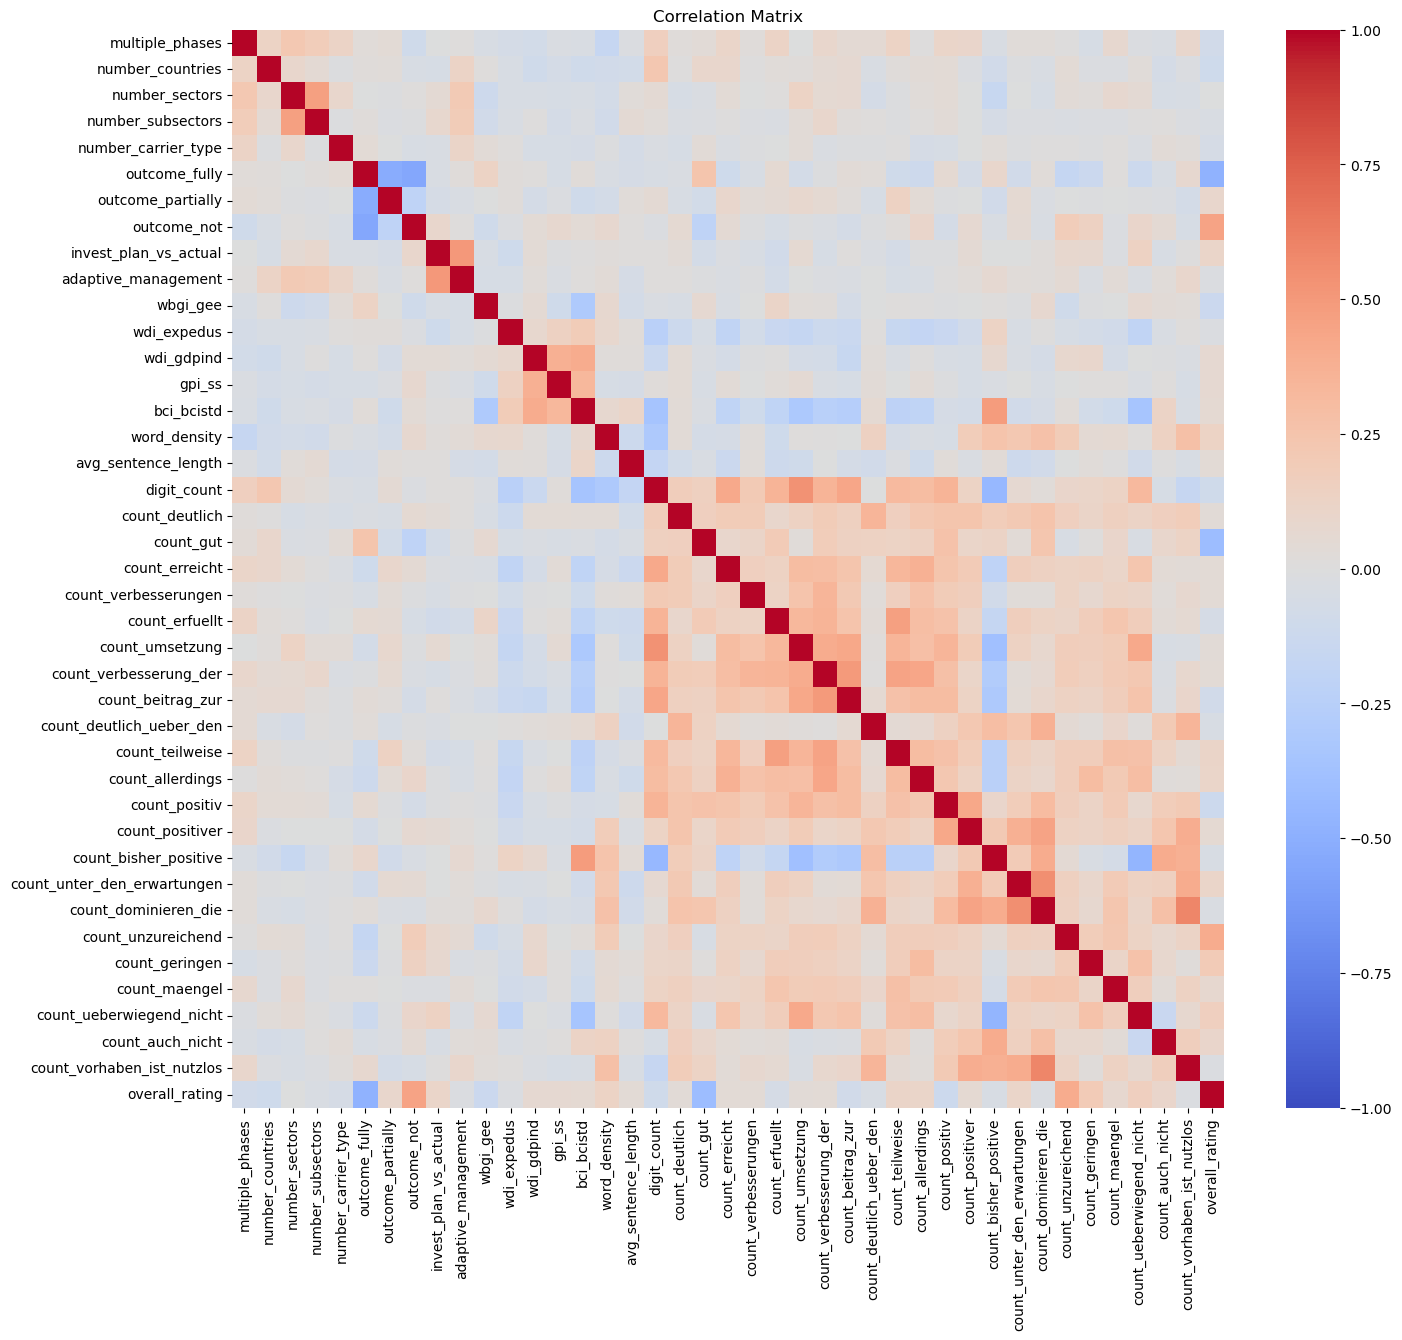

In [10]:
corr_matrix = train_test_data_clean.corr()

# Plot the correlation matrix
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

In [11]:
FEATURES = ['multiple_phases', 'number_countries', 'number_sectors',
       'number_subsectors', 'number_carrier_type', 'outcome_fully',
       'outcome_partially', 'outcome_not', 'invest_plan_vs_actual',
       'adaptive_management', 'wbgi_gee', 'wdi_expedus', 'wdi_gdpind',
       'gpi_ss', 'bci_bcistd', 'word_density', 'avg_sentence_length',
       'digit_count', 'count_deutlich', 'count_gut', 'count_erreicht',
       'count_verbesserungen', 'count_erfuellt', 'count_umsetzung',
       'count_verbesserung_der', 'count_beitrag_zur',
       'count_deutlich_ueber_den', 'count_teilweise', 'count_allerdings',
       'count_positiv', 'count_positiver', 'count_bisher_positive',
       'count_unter_den_erwartungen', 'count_dominieren_die',
       'count_unzureichend', 'count_geringen', 'count_maengel',
       'count_ueberwiegend_nicht', 'count_auch_nicht',
       'count_vorhaben_ist_nutzlos']

TARGET = 'overall_rating'

Next, we want to do more specific feature selection with lasso regression and random forest feature importance.

Best alpha value found by cross-validation: 0.02811768697974228
 
Lasso Coefficients with best alpha:
 multiple_phases               -0.016512
number_countries              -0.034176
number_sectors                -0.003851
number_subsectors             -0.000000
number_carrier_type           -0.026532
outcome_fully                 -0.190895
outcome_partially             -0.000000
outcome_not                    0.137658
invest_plan_vs_actual          0.000000
adaptive_management           -0.000000
wbgi_gee                      -0.030462
wdi_expedus                   -0.000000
wdi_gdpind                    -0.000000
gpi_ss                         0.000256
bci_bcistd                     0.000000
word_density                   0.000000
avg_sentence_length            0.000000
digit_count                   -0.026411
count_deutlich                 0.000000
count_gut                     -0.233333
count_erreicht                 0.000000
count_verbesserungen           0.000000
count_erfuellt   

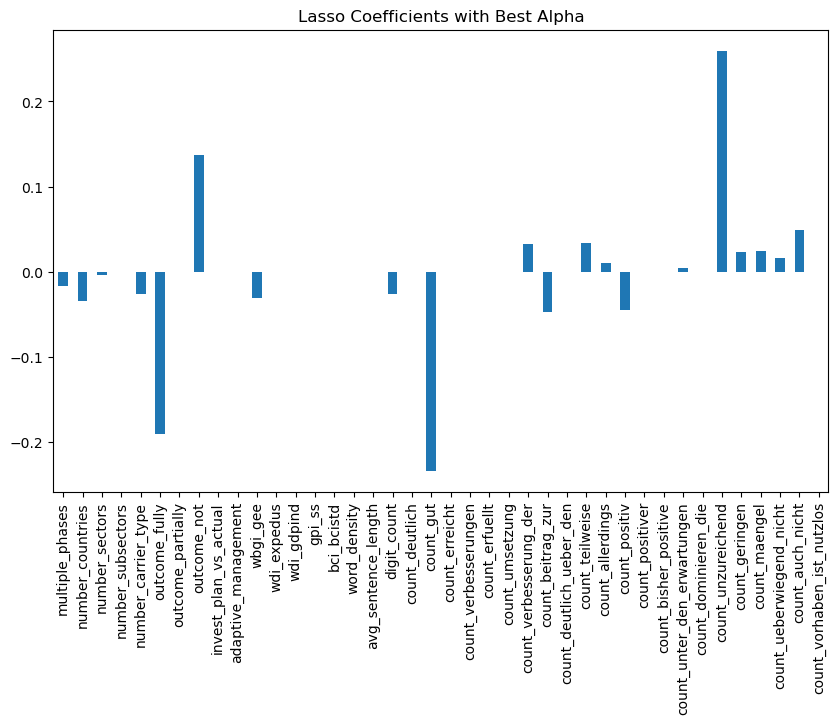

Mean Squared Error with best alpha: 0.40521037070539395
 
Selected Features: ['multiple_phases', 'number_countries', 'number_sectors', 'number_carrier_type', 'outcome_fully', 'outcome_not', 'wbgi_gee', 'gpi_ss', 'digit_count', 'count_gut', 'count_verbesserung_der', 'count_beitrag_zur', 'count_teilweise', 'count_allerdings', 'count_positiv', 'count_unter_den_erwartungen', 'count_unzureichend', 'count_geringen', 'count_maengel', 'count_ueberwiegend_nicht', 'count_auch_nicht']


In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Data
X = train_test_data[FEATURES]
y = train_test_data[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Pipeline
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=22)),
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(alphas=np.logspace(-4, 0, 50), cv=5, random_state=123, max_iter=30000))
])

# Fitting
pipeline.fit(X_train, y_train)

# LassoCV
best_alpha = pipeline.named_steps['lasso'].alpha_
print("Best alpha value found by cross-validation:", best_alpha)
print(" ")

coefficients = pd.Series(pipeline.named_steps['lasso'].coef_, index=X.columns)
print("Lasso Coefficients with best alpha:\n", coefficients)

# Plotting
plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar')
plt.title("Lasso Coefficients with Best Alpha")
plt.show()

# Evaluation
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error with best alpha:", mse)
print(" ")

# Features
selected_features = coefficients[coefficients != 0].index.tolist()
print("Selected Features:", selected_features)

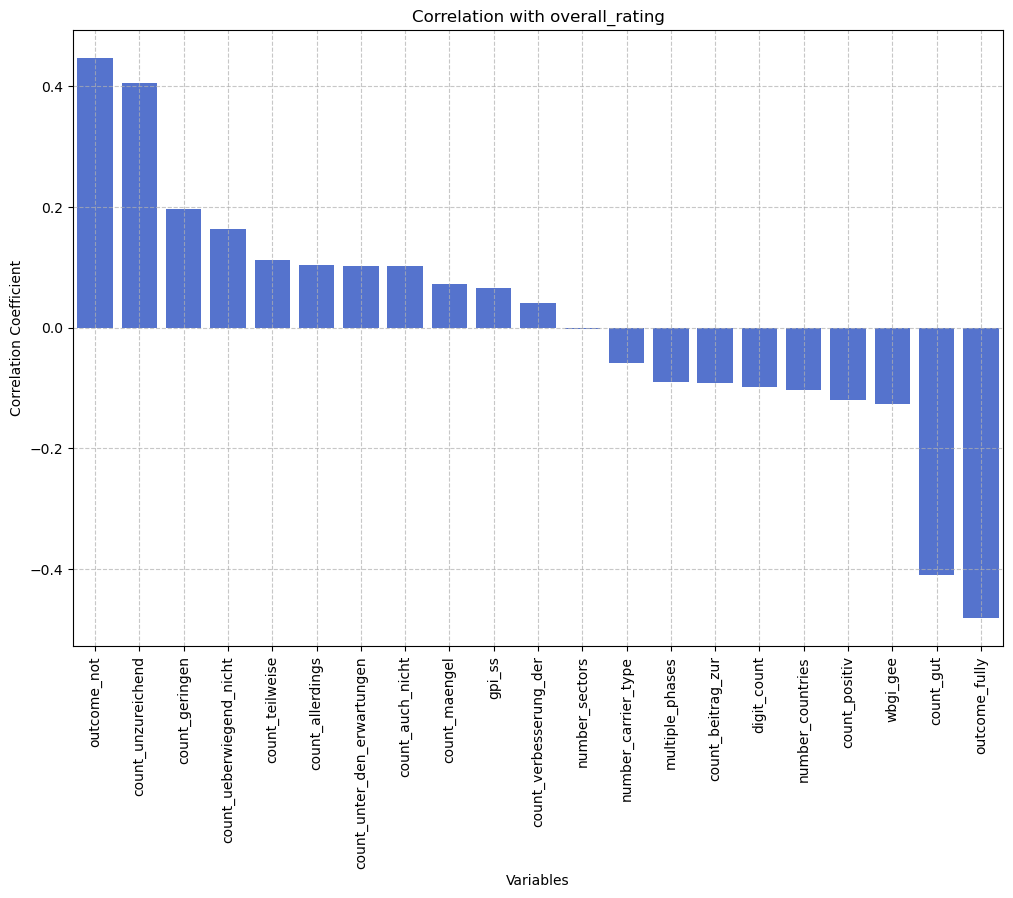

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

target_corr = train_test_data_clean[selected_features].corrwith(train_test_data_clean[TARGET])

# Sorting
sorted_target_corr = target_corr.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_target_corr.index, y=sorted_target_corr.values, color='royalblue')
plt.title(f'Correlation with {TARGET}')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Since the variable 'number_sectors' does not correlate with 'overall_rating', we drop it from our features list.

In [14]:
selected_features.remove("number_sectors")

FEATURES = list(selected_features)
TARGET = "overall_rating"

We are now calculating the training and testing RMSE for every model.

In [15]:
from sklearn.model_selection import cross_validate

# Models
models = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=22)),
        ('linear', LinearRegression())
    ]),
    'Ridge Regression': Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=22)),
        ('ridge', Ridge(random_state=123))
    ]),
    'Lasso Regression': Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=22)),
        ('lasso', Lasso(random_state=123, max_iter=5000))
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=22)),
        ('randomforestregressor', RandomForestRegressor(random_state=123))
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=22)),
        ('gradientboostingregressor', GradientBoostingRegressor(random_state=123))
    ]),
    'Support Vector Regression': Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=22)),
        ('svr', SVR())
    ]),
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=22)),
        ('xgbregressor', xgb.XGBRegressor(random_state=123))
    ]),
    'LightGBM': Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=22)),
        ('lgbmregressor', lgb.LGBMRegressor(random_state=123, verbose=-1))
    ])
}

# Variables
X_train_test = train_test_data[FEATURES]
y_train_test = train_test_data[TARGET]

# RMSE results
rmse_results = {}

for name, pipeline in models.items():
    cv_results = cross_validate(pipeline, X_train_test, y_train_test, 
                                scoring='neg_mean_squared_error', 
                                cv=10, 
                                return_train_score=True)
    
    train_rmse_scores = np.sqrt(-cv_results['train_score'])
    test_rmse_scores = np.sqrt(-cv_results['test_score'])
    
    average_train_rmse = train_rmse_scores.mean()
    std_train_rmse = train_rmse_scores.std()
    
    average_test_rmse = test_rmse_scores.mean()
    std_test_rmse = test_rmse_scores.std()
    
    rmse_results[name] = {
        'average_train_rmse': average_train_rmse,
        'std_train_rmse': std_train_rmse,
        'average_test_rmse': average_test_rmse,
        'std_test_rmse': std_test_rmse
    }

    print(f"Model: {name}")
    print(f"Cross-validated Average Train RMSE: {average_train_rmse:.4f}. Std: ±{std_train_rmse:.4f}")
    print(f"Cross-validated Average Test RMSE: {average_test_rmse:.4f}. Std: ±{std_test_rmse:.4f}")
    print(" ")

Model: Linear Regression
Cross-validated Average Train RMSE: 0.6159. Std: ±0.0073
Cross-validated Average Test RMSE: 0.6389. Std: ±0.0672
 
Model: Ridge Regression
Cross-validated Average Train RMSE: 0.6159. Std: ±0.0073
Cross-validated Average Test RMSE: 0.6388. Std: ±0.0672
 
Model: Lasso Regression
Cross-validated Average Train RMSE: 0.8833. Std: ±0.0092
Cross-validated Average Test RMSE: 0.8821. Std: ±0.0838
 
Model: Random Forest
Cross-validated Average Train RMSE: 0.2426. Std: ±0.0032
Cross-validated Average Test RMSE: 0.6473. Std: ±0.0701
 
Model: Gradient Boosting
Cross-validated Average Train RMSE: 0.4190. Std: ±0.0064
Cross-validated Average Test RMSE: 0.6388. Std: ±0.0675
 
Model: Support Vector Regression
Cross-validated Average Train RMSE: 0.4711. Std: ±0.0072
Cross-validated Average Test RMSE: 0.6640. Std: ±0.0756
 
Model: XGBoost
Cross-validated Average Train RMSE: 0.0102. Std: ±0.0021
Cross-validated Average Test RMSE: 0.6747. Std: ±0.0612
 
Model: LightGBM
Cross-valida

Based on the results we decide to do parameter tuning for the Gradient Boosting Model.

In [16]:
X = train_test_data[FEATURES]
y = train_test_data[TARGET]

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('imputer', KNNImputer(n_neighbors=22)),
    ('gradientboostingregressor', GradientBoostingRegressor(random_state=123))
])

# Grid
param_grid = {
    'gradientboostingregressor__n_estimators': [100, 300, 500],
    'gradientboostingregressor__learning_rate': [0.1, 0.2],
    'gradientboostingregressor__max_depth': [2, 3, 5],
    'gradientboostingregressor__min_samples_split': [2, 3, 4],
    'gradientboostingregressor__min_samples_leaf': [1, 3, 5]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print("Best Parameters:", best_params)
print("Best RMSE from Cross-Validation:", best_score)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 2, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__n_estimators': 100}
Best RMSE from Cross-Validation: 0.6362944276546474


Now we are using our fine tuned model and also display validation errror:

In [17]:
# Models
models = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=22)),
        ('linear', LinearRegression())
    ]),
    'Ridge Regression': Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=22)),
        ('ridge', Ridge(random_state=123))
    ]),
    'Lasso Regression': Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=22)),
        ('lasso', Lasso(random_state=123, max_iter=5000))
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=22)),
        ('randomforestregressor', RandomForestRegressor(random_state=123))
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=22)),
        ('gradientboostingregressor', GradientBoostingRegressor(
            random_state=123,
            n_estimators=100,
            max_depth=2,
            min_samples_split=2,
            min_samples_leaf=1,
            learning_rate=0.1
        ))
    ]),
    'Support Vector Regression': Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=22)),
        ('svr', SVR())
    ]),
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=22)),
        ('xgbregressor', xgb.XGBRegressor(random_state=123))
    ]),
    'LightGBM': Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=22)),
        ('lgbmregressor', lgb.LGBMRegressor(random_state=123, verbose=-1))
    ])
}

# Variables
X_train_test = train_test_data[FEATURES]
y_train_test = train_test_data[TARGET]
X_val = validation_data[FEATURES]
y_val = validation_data[TARGET]

# RMSE results
rmse_results = {}
validation_results = {}

for name, pipeline in models.items():
    # Cross-validation on training data
    cv_results = cross_validate(pipeline, X_train_test, y_train_test, 
                                scoring='neg_mean_squared_error', 
                                cv=10, 
                                return_train_score=True)
    
    train_rmse_scores = np.sqrt(-cv_results['train_score'])
    test_rmse_scores = np.sqrt(-cv_results['test_score'])
    
    average_train_rmse = train_rmse_scores.mean()
    std_train_rmse = train_rmse_scores.std()
    
    average_test_rmse = test_rmse_scores.mean()
    std_test_rmse = test_rmse_scores.std()
    
    rmse_results[name] = {
        'average_train_rmse': average_train_rmse,
        'std_train_rmse': std_train_rmse,
        'average_test_rmse': average_test_rmse,
        'std_test_rmse': std_test_rmse
    }
    
    # Train on full train_test_data
    pipeline.fit(X_train_test, y_train_test)
    
    # Predict on validation data
    y_pred = pipeline.predict(X_val)
    validation_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    validation_results[name] = validation_rmse
    
    print(f"Model: {name}")
    print(f"Cross-validated Average Train RMSE: {average_train_rmse:.4f}. Std: ±{std_train_rmse:.4f}")
    print(f"Cross-validated Average Test RMSE: {average_test_rmse:.4f}. Std: ±{std_test_rmse:.4f}")
    print(f"Validation RMSE: {validation_rmse:.4f}")
    print(" ")

Model: Linear Regression
Cross-validated Average Train RMSE: 0.6159. Std: ±0.0073
Cross-validated Average Test RMSE: 0.6389. Std: ±0.0672
Validation RMSE: 0.6891
 
Model: Ridge Regression
Cross-validated Average Train RMSE: 0.6159. Std: ±0.0073
Cross-validated Average Test RMSE: 0.6388. Std: ±0.0672
Validation RMSE: 0.6892
 
Model: Lasso Regression
Cross-validated Average Train RMSE: 0.8833. Std: ±0.0092
Cross-validated Average Test RMSE: 0.8821. Std: ±0.0838
Validation RMSE: 0.8625
 
Model: Random Forest
Cross-validated Average Train RMSE: 0.2426. Std: ±0.0032
Cross-validated Average Test RMSE: 0.6473. Std: ±0.0701
Validation RMSE: 0.7203
 
Model: Gradient Boosting
Cross-validated Average Train RMSE: 0.5071. Std: ±0.0058
Cross-validated Average Test RMSE: 0.6288. Std: ±0.0705
Validation RMSE: 0.6788
 
Model: Support Vector Regression
Cross-validated Average Train RMSE: 0.4711. Std: ±0.0072
Cross-validated Average Test RMSE: 0.6640. Std: ±0.0756
Validation RMSE: 0.6741
 
Model: XGBoost

When it comes to validation error, the Gradient Boosting Model and the Support Vector Regression perform best. Also more simpler models like Linear Regression and Ridge Regression perform decent.